Notebook to walk you through the flair package- Typical MPRA analysis

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.gridspec as gsp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import scipy.stats as stats 
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))  
from scipy.special import gamma, factorial,digamma
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.special as sp 
from scipy import integrate
from joblib import Parallel, delayed

import sys
sys.path.append(r'/Users/ys18223/Documents/GitHub/FORECAST_BiocomputeLab')

import forecast
import forecast.inference as infer
#import flair.flair as fl
import forecast.cheat_codes as cc

# Inference with lognormal distribution

Import experimental parameters into Experiment class:

In [3]:
Bins=16
Nj=np.array([787412,982020,1465090,1401737,1025836,963772,1043910,1058248,1368234,1473916,2051185,2401738,2235051,1918568,1578880,412599]).astype(float) #FACS events in each bin ( Number of cells sorted in each bin) Must be a numpy array of dtype=float
Reads=np.array([ 382313.,  952717.,  701430.,  819585., 1074847., 1600514.,2211263., 2471743., 3347620., 3671715., 5220533., 6022885.,5746555., 4967160., 3994495., 1041134.]).astype(float) #Number of reads allocated in each bin Must be a numpy array of dtype=float
Sij=np.load('Reads_count.npy').astype(int) #Filtered Read Counts for each genetic construct (one row) in each bin (one column) Must be a numpy array of dtype=int
Fluorescence_max=10**6  #Max fluorescence of the FACS
Distribution='lognormal' #Fluorescence distribution to choose between lognormal and gamma
Diversity=len(Sij)

#Experiment Class
MyExperiment=forecast.Experiment(Bins,Diversity,Nj,Reads,Sij,Fluorescence_max,Distribution)

In [4]:
np.sum(Reads)/len(Sij),np.sum(Nj)/len(Sij)

(181.2561844262295, 90.85326229508196)

In [17]:
Tableau=infer.inference(0,1000+1,MyExperiment)  #Inference from construct 0 to construct 100 (according to the referencing system in Sij), the results are stored in the new dataframe named 'Tableau'

In [6]:
Tableau=Tableau[Tableau['sigma_MLE']>Tableau['sigma_std']]
Tableau=Tableau[Tableau['mu_MLE']>Tableau['mu_std']]
Tableau=Tableau[Tableau['mu_MLE']>0]
Tableau=Tableau[Tableau['Inference_grade']==1]
Tableau=Tableau[Tableau['Score']<=0.7]
len(Tableau)
Tableau.head(8)

,mu_MLE,sigma_MLE,mu_std,sigma_std,mu_MOM,sigma_MOM,Inference_grade,Score
0,8.079155,0.608605,0.032830,0.025055,8.068880,0.644421,1.0,0.0
1,8.817682,0.858641,0.044398,0.032379,8.832912,0.861749,1.0,0.0
3,9.004134,0.605289,0.047331,0.035957,9.020377,0.648858,1.0,0.0
4,6.119546,0.480419,0.039623,0.030925,6.091100,0.452365,1.0,0.0
5,8.961361,0.586036,0.083259,0.064462,8.953802,0.653688,1.0,0.0
9,5.444311,0.575214,0.042303,0.033109,5.447053,0.626227,1.0,0.0
10,5.784326,1.636780,0.090212,0.064342,5.974940,1.254084,1.0,0.0
11,4.776173,0.587808,0.057860,0.045347,4.769641,0.642483,1.0,0.0


In [ ]:
Tableau

8.07915486068979 0.6086054698244034 8.068880292879367 0.6444210394444337


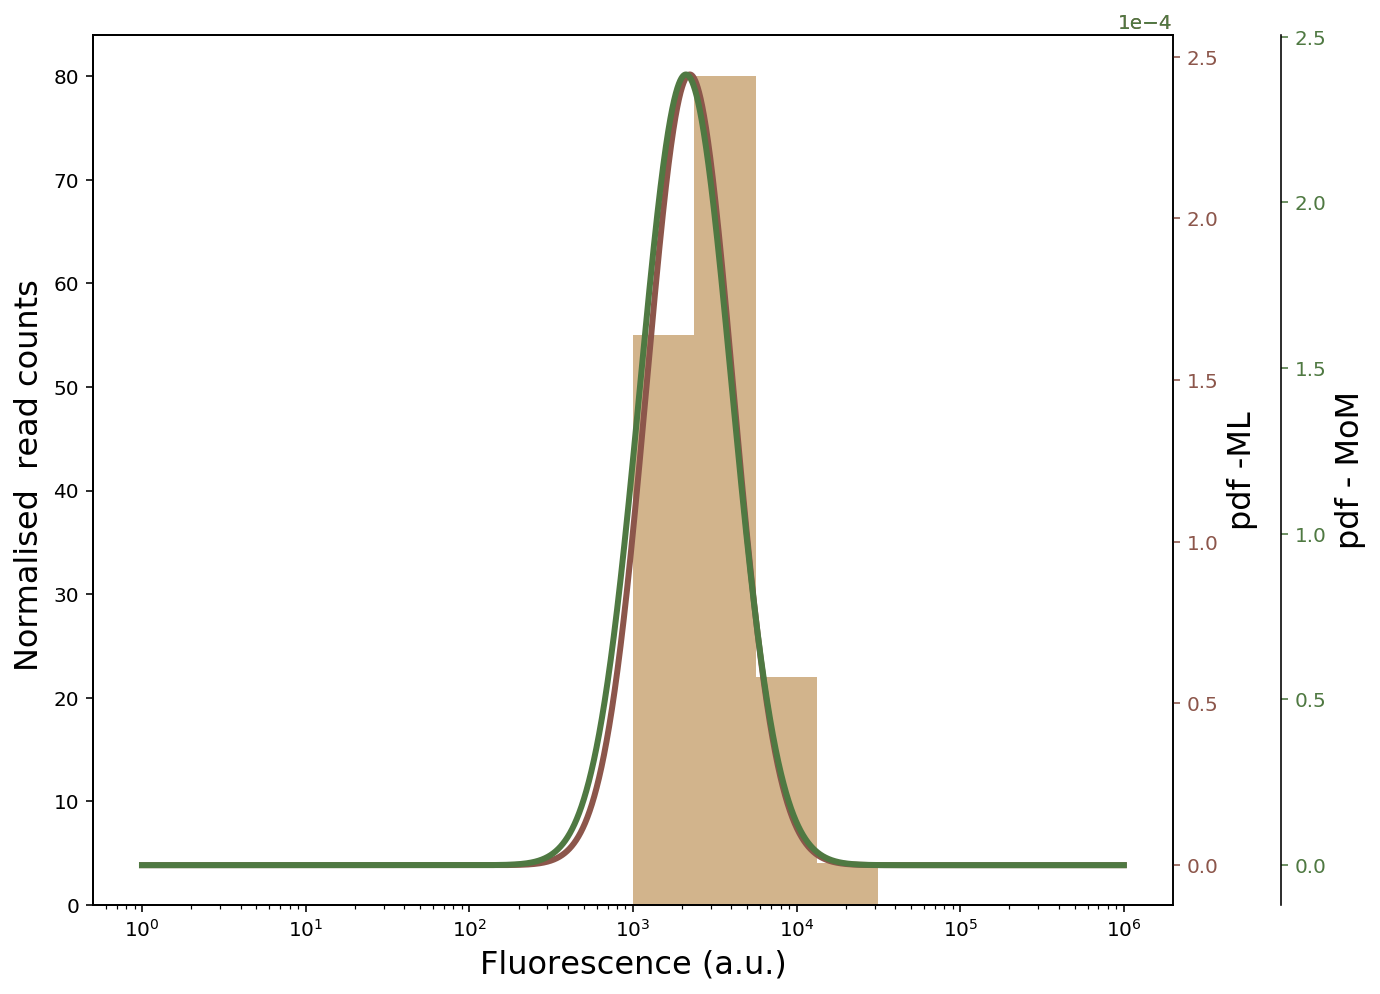

In [16]:
def data_transformation_bins(X):  #New representation of the data enabling the method of moments
    X=X.astype(int)
    T=np.repeat(np.exp(MyExperiment.mean_assigned),X)
    return(T)

i=0
x = np.linspace(1, 1e6, 5000000)
a =Tableau.iloc[i,0]
b =Tableau.iloc[i,1]
a2 = Tableau.iloc[i,4]
b2= Tableau.iloc[i,5]

#Data
y_mle =stats.lognorm.pdf(x, s=b, scale=np.exp(a)) # the normal pTableau
y_mom=stats.lognorm.pdf(x, s=b2, scale=np.exp(a2))

#Graph
fig, ax = plt.subplots(figsize=(12,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.1))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)
# And finally we get to plot things...
colors = ('tan','tab:brown', '#4f7942')
axes[0].hist(data_transformation_bins(MyExperiment.nijhat[i,:]),bins=np.logspace(0,np.log10(Fluorescence_max),Bins+1),zorder=0,color='tan',label='Read count')
axes[1].plot(x, y_mle, label='ML reconstruction',linewidth=3,zorder=5,color='tab:brown')
axes[2].plot(x, y_mom, label='MOM reconstruction',linewidth=3,zorder=3,c='#4f7942')

axes[0].set_ylabel('Normalised  read counts ',fontsize=16)
axes[1].set_ylabel('pdf -ML',fontsize=16)
axes[2].set_ylabel('pdf - MoM',fontsize=16)
#plt.legend(frameon=False ,fontsize=20,markerscale=3)
axes[1].tick_params(axis='y', colors=colors[1])
axes[2].tick_params(axis='y', colors=colors[2])
axes[0].set_xlabel('Fluorescence (a.u.)',fontsize=16)
axes[1].ticklabel_format(axis="y",style="sci", scilimits=(0,0))
axes[2].ticklabel_format(axis="y",style="sci", scilimits=(0,0))
plt.xscale('log')
print(a,b,a2,b2)

# Inference with gamma distribution

In [8]:
MyExperiment2=forecast.Experiment(Bins,Diversity,Nj,Reads,Sij,Fluorescence_max,'gamma')

In [9]:
Tableau2=infer.inference(0,100+1,MyExperiment2)  #Inference from construct 79811 to construct 79830 (according to the referencing system in Sij), the results are stored in the new dataframe named 'Tableau'

In [10]:
Tableau2.head()

,a_MLE,b_MLE,a_std,b_std,mu_MOM,sigma_MOM,Inference_grade,Score
0,2.675144,1467.712551,0.208339,126.511882,4415.932549,3785.768168,1.0,0.0
1,1.675635,5579.014281,0.120571,467.621128,10739.956573,11730.678792,1.0,0.0
2,92.966688,24.008876,0.000000,0.000000,2199.399436,1019.366806,2.0,0.0
3,3.168965,3030.606234,0.363967,387.730396,10975.509645,6715.572911,1.0,0.0
4,5.282278,93.442315,0.697914,12.995141,530.457281,208.226689,1.0,0.0


2.6751435449172236 1467.7125511538873 1.3606199416868796 3245.529786494901


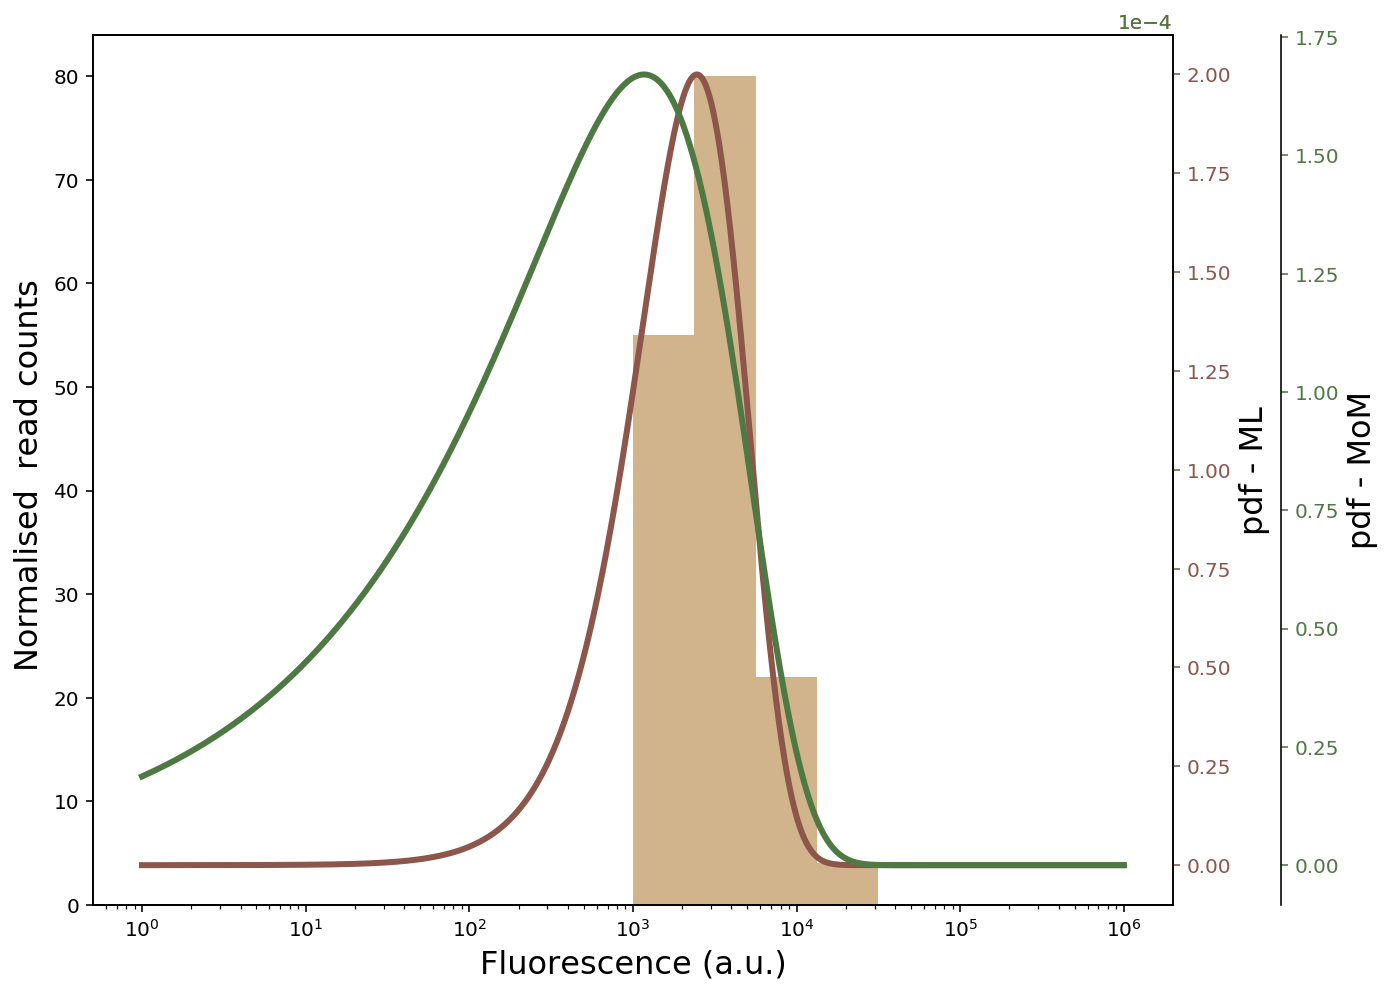

In [15]:
def data_transformation_bins(X):  #New representation of the data enabling the method of moments
    X=X.astype(int)
    T=np.repeat(MyExperiment2.mean_assigned,X)
    return(T)

i=0
x = np.linspace(1, 1e6, 5000000)
a =Tableau2.iloc[i,0]
b =Tableau2.iloc[i,1]
a2,b2 =cc.ms_to_ab(Tableau2.iloc[i,4],Tableau2.iloc[i,5])
#Data
y_mle =stats.gamma.pdf(x, a, scale=b) # the normal pdf
y_mom=stats.gamma.pdf(x,a2,scale=b2)

#Graph
fig, ax = plt.subplots(figsize=(12,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.1))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)
# And finally we get to plot things...
colors = ('tan','tab:brown', '#4f7942')
axes[0].hist(data_transformation_bins(MyExperiment2.nijhat[i,:]),bins=np.logspace(0,np.log10(Fluorescence_max),Bins+1),zorder=0,color='tan',label='Read count')
axes[1].plot(x, y_mle, label='ML reconstruction',linewidth=3,zorder=5,color='tab:brown')
axes[2].plot(x, y_mom, label='MOM reconstruction',linewidth=3,zorder=3,c='#4f7942')

axes[0].set_ylabel('Normalised  read counts ',fontsize=16)
axes[1].set_ylabel('pdf - ML',fontsize=16)
axes[2].set_ylabel('pdf - MoM',fontsize=16)
#plt.legend(frameon=False ,fontsize=20,markerscale=3)
axes[1].tick_params(axis='y', colors=colors[1])
axes[2].tick_params(axis='y', colors=colors[2])
axes[0].set_xlabel('Fluorescence (a.u.)',fontsize=16)
axes[1].ticklabel_format(axis="y",style="sci", scilimits=(0,0))
axes[2].ticklabel_format(axis="y",style="sci", scilimits=(0,0))
plt.xscale('log')
print(a,b,a2,b2)
